# Exploratory analysis for year 2005
Exploratory data analysis for diplomatic relations for year 2005.

Run `diplomatic_exchanges.py` file first to create a db with data.

In [4]:
import networkx as nx
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [36]:
import os
if not os.path.exists('./plots/'):
    os.mkdir('./plots')
if not os.path.exists('./plots/demo'):
    os.mkdir('./plots/demo')

In [5]:
df = pd.read_csv('./Diplomatic_Exchange_2006v1.csv')

In [6]:
df.head()

,ccode1,ccode2,year,DR_at_1,DR_at_2,DE,version
0,2,20,1920,0,0,0,2006.099976
1,2,20,1925,0,0,0,2006.099976
2,2,20,1930,0,2,1,2006.099976
3,2,20,1935,2,2,1,2006.099976
4,2,20,1940,2,2,1,2006.099976


In [7]:
conn = sqlite3.connect('diplomatic.db')

In [8]:
# # unweighted
# q = """
#     select * from diplomatic_exchages de
#     where year = 2005 and DE = 1 and DR_at_1 = 3
# """

# weighted
q =""" 
select *  from diplomatic_exchages de 
where DE=1 and DR_at_1 = 3 and "year" = 2005 and DR_at_2 != 9
"""
df_2005 = pd.read_sql(q, conn)

In [9]:
df_2005.head()

,index,ccode1,ccode2,year,DR_at_1,DR_at_2,DE,version
0,16,2,20,2005,3,3,1,2006.099976
1,23,2,31,2005,3,3,1,2006.099976
2,69,2,41,2005,3,3,1,2006.099976
3,90,2,42,2005,3,3,1,2006.099976
4,99,2,51,2005,3,3,1,2006.099976


In [10]:
df_2005.shape

(7470, 8)

In [11]:
# Create directed graph
%time G = nx.from_pandas_edgelist(df_2005[['ccode1', 'ccode2', 'DR_at_2']], source = 'ccode1', target = 'ccode2',edge_attr='DR_at_2', create_using=nx.DiGraph)

CPU times: total: 62.5 ms
Wall time: 48 ms


In [12]:
# adjacency matrix
H = nx.adjacency_matrix(G)
H

C:\Users\LoizosLaptop\AppData\Local\Temp\ipykernel_21716\3228295649.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  H = nx.adjacency_matrix(G)


<192x192 sparse matrix of type '<class 'numpy.intc'>'
	with 7470 stored elements in Compressed Sparse Row format>

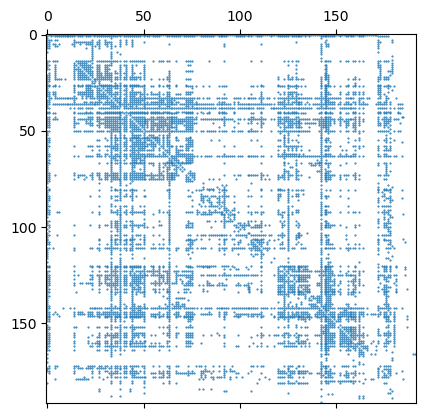

In [37]:
# plot adjacency matrix
fig, ax = plt.subplots(1,1, figsize=(6.4, 4.8))
ax.spy(H, markersize =1, marker = '.')
fig.savefig('./plots/demo/adj_matr_2005.png', dpi=300)

In [14]:
page_rank_scores_dict = nx.pagerank(G, weight='DR_at_2') 

In [15]:
page_rank_scores = [page_rank_scores_dict[node] for node in page_rank_scores_dict]

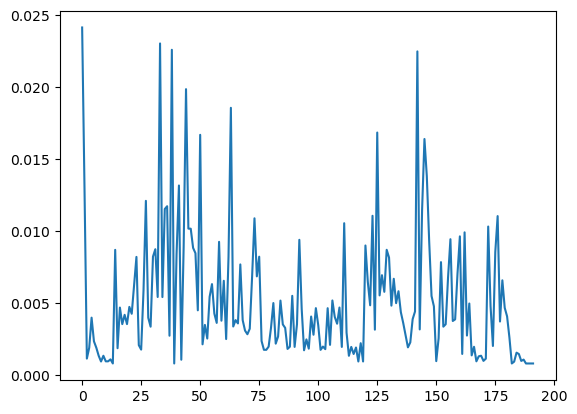

In [17]:
plt.plot(page_rank_scores)

In [21]:
# country codes maping

In [22]:
import csv

In [23]:
with open('./COW-country-codes.csv', 'r') as f:
    country_codes_dict = {int(row['CCode']): row['StateNme'] for row in csv.DictReader(f)}

In [24]:

country_codes_dict[2]

'United States of America'

In [25]:
# Sort the score dictionary by values
page_rank_scores_dict_sorted = dict(sorted(page_rank_scores_dict.items(), key=lambda x: x[1], reverse=True))

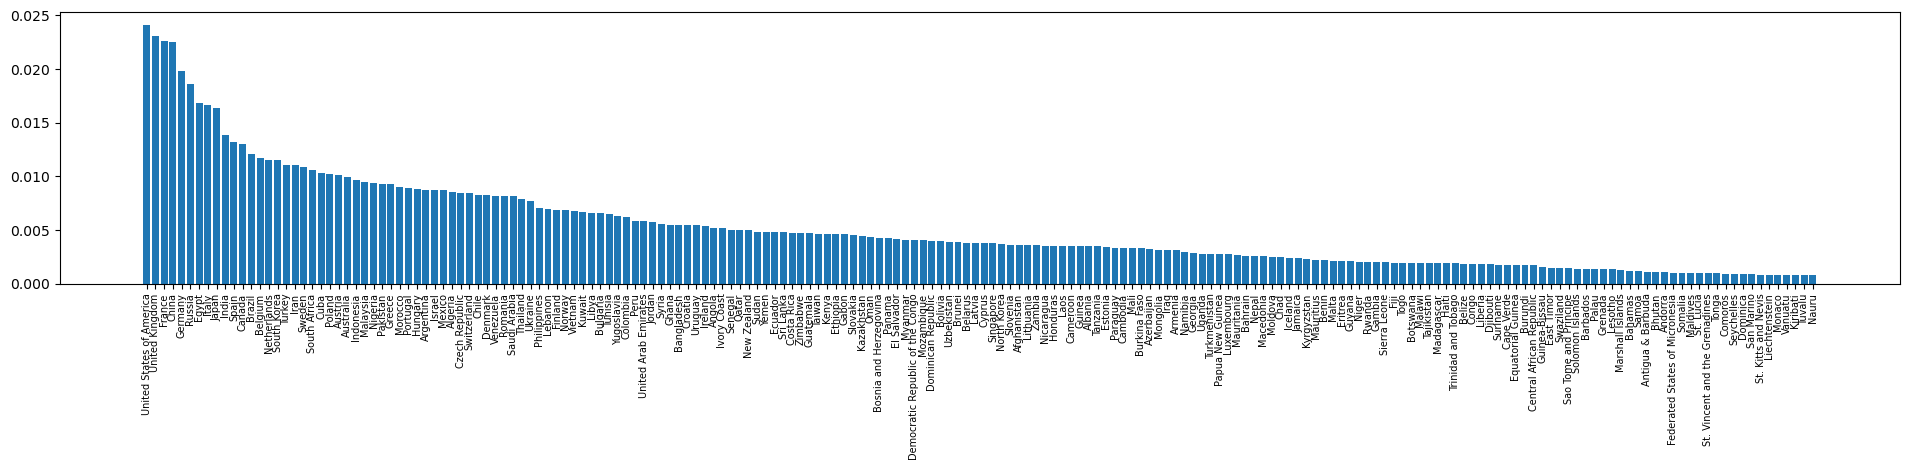

In [38]:
fig, ax = plt.subplots(1,1, figsize=(3*6.4, 4.8), tight_layout=True)

plt.bar(list(map(lambda x: country_codes_dict[x], page_rank_scores_dict_sorted.keys())), page_rank_scores_dict_sorted.values())
plt.xticks(rotation=90, fontsize=7);
fig.savefig('./plots/demo/2005_pagerank_weighted.png', dpi=300)
# ax.tick_params(axis='x', which='major', labelsize=8)

In [27]:
# normalize scores

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1,10))

In [29]:
page_rank_scores_scaled = scaler.fit_transform(np.array(page_rank_scores).reshape(-1,1)).flatten()

In [30]:
# visualize network

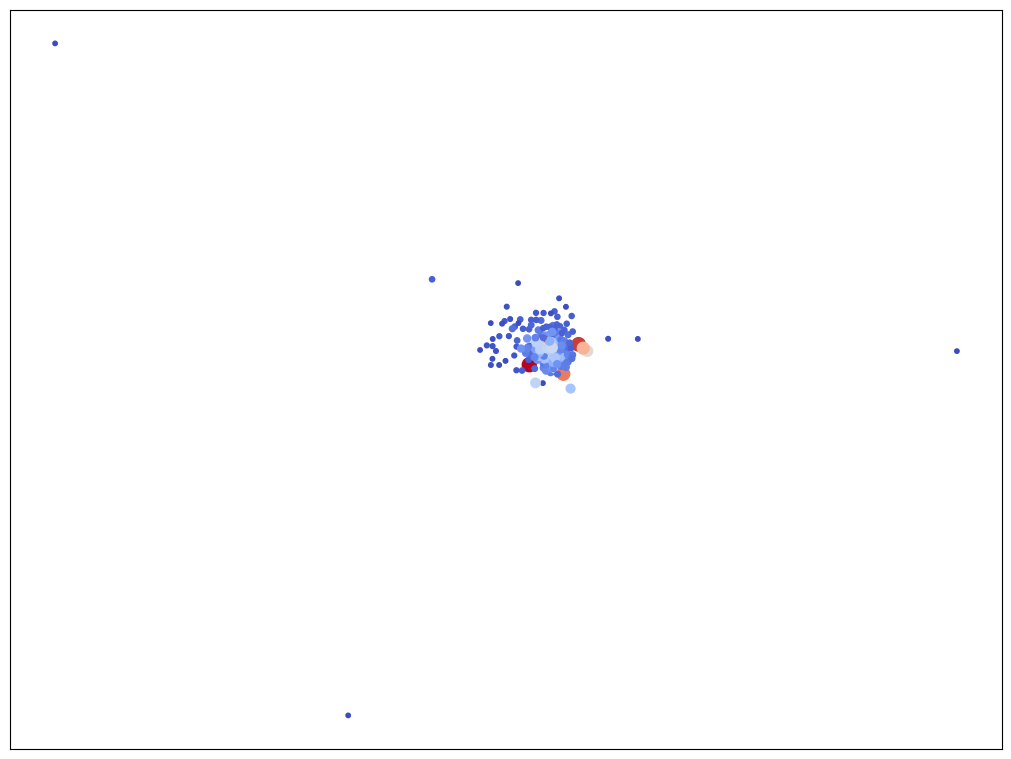

In [39]:
fig, ax = plt.subplots(1,1, figsize=(2*6.4, 2*4.8))

# layout = nx.random_layout(G, seed=42)
layout = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos=layout, node_size = 10*page_rank_scores_scaled,
node_color = page_rank_scores_scaled, cmap='coolwarm', ax=ax)
fig.savefig('./plots/demo/graph_pagerank_2005.png', dpi = 300)

In [40]:
# check the top 10 nodes graph

In [41]:
country_codes_dict[365], country_codes_dict[710]

('Russia', 'China')

In [42]:
top_10_nodes = list(page_rank_scores_dict_sorted.keys())[:10]
top10_subgraph = G.subgraph(top_10_nodes)

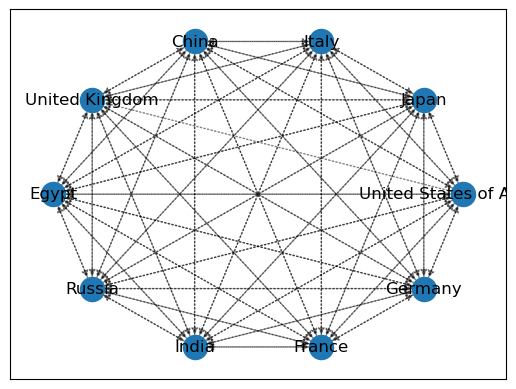

In [43]:
# nx.draw(top10_subgraph)
fig, ax = plt.subplots(1,1, figsize=(6.4, 4.8))
layout = nx.circular_layout(top10_subgraph)#, seed=42)
# nx.draw_networkx(top10_subgraph, layout)
nx.draw_networkx_nodes(top10_subgraph, pos=layout, ax=ax)#,node_size = 50*page_rank_scores_scaled, node_color = page_rank_scores_scaled, cmap='coolwarm', ax=ax)
nx.draw_networkx_edges(top10_subgraph, pos=layout, alpha=0.5,ax=ax, style='dotted');
nx.draw_networkx_labels(top10_subgraph, layout, {i: country_codes_dict[i] for i in top10_subgraph.nodes()}, ax=ax);
fig.savefig('./plots/demo/top10nodes_pagerank_2005.png', dpi=200)

In [48]:
# check their connections

In [49]:
nx.adjacency_matrix(top10_subgraph).todense()

C:\Users\LoizosLaptop\AppData\Local\Temp\ipykernel_21716\2824506195.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(top10_subgraph).todense()


matrix([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=int32)

In [50]:
country_codes_dict[2], country_codes_dict[200]

('United States of America', 'United Kingdom')

In [53]:
# these top countries are not connected
print((2, 200) in list(top10_subgraph.edges))
print((200, 2) in list(top10_subgraph.edges))
print(country_codes_dict[2], country_codes_dict[200])

True
False
United States of America United Kingdom


In [54]:
# check the top 4 nodes connections with the rest of the nodes

In [55]:
top_4_nodes =  list(page_rank_scores_dict_sorted.keys())[:4]
top_4_graph = nx.DiGraph() 

# Add the edges between the subset nodes and the rest of the nodes
for node in G.nodes():
    if node in top_4_nodes:
        for neighbor in G.neighbors(node):
            top_4_graph.add_edge(node, neighbor, )
            # if neighbor not in top_3_nodes: # dont need this
            #     top_10_graph.add_edge(node, neighbor)

In [56]:
# pos = nx.spring_layout(top_10_graph, seed=42)
# nx.draw(top_10_graph, pos)

In [57]:
filtered_G = nx.DiGraph()

# Add the nodes from the full graph to the filtered graph
for node in G.nodes():
    filtered_G.add_node(node)

# Add the edges from the subset_edges to the filtered graph
for edge in top_4_graph.edges:
    filtered_G.add_edge(*edge)

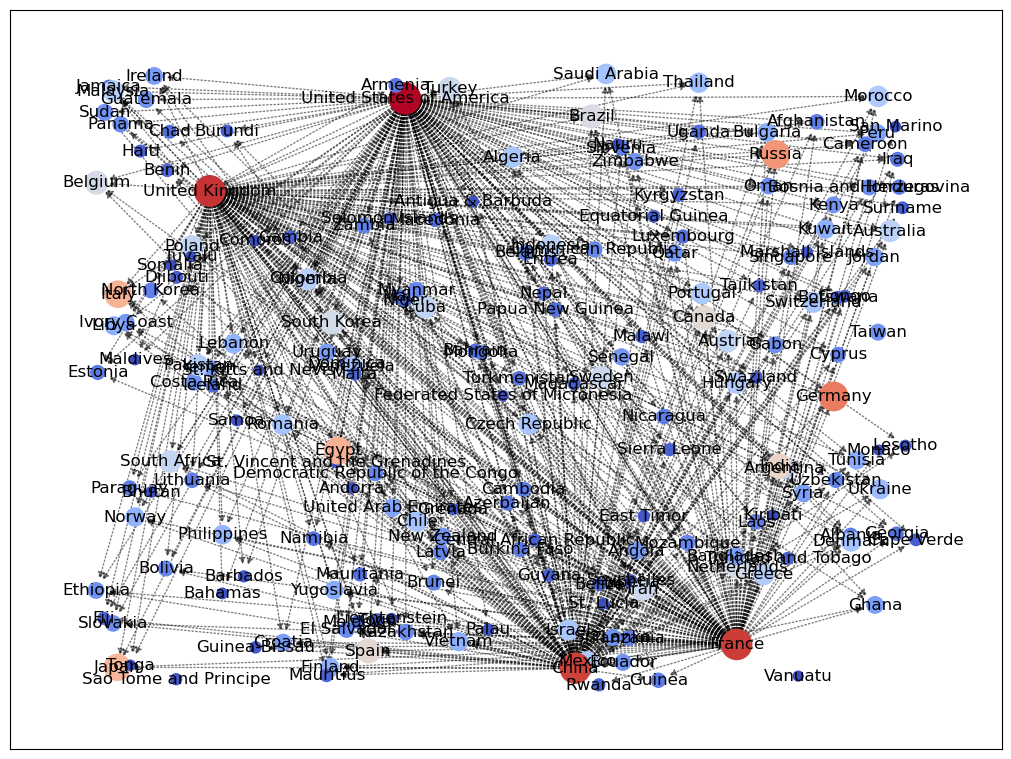

In [58]:
fig, ax = plt.subplots(1,1, figsize=(2*6.4, 2*4.8))

# layout = nx.nx_agraph.graphviz_layout(filtered_G)
layout = nx.random_layout(G, seed=42)

nx.draw_networkx_nodes(filtered_G, pos=layout,node_size = 50*page_rank_scores_scaled, node_color = page_rank_scores_scaled, cmap='coolwarm', ax=ax)
nx.draw_networkx_edges(filtered_G, pos=layout, alpha=0.5,ax=ax, style='dotted');
nx.draw_networkx_labels(filtered_G, layout, {i: country_codes_dict[i] for i in filtered_G.nodes()}, ax=ax);
fig.savefig('./plots/demo/graph_top4_nodes_pagerank_2005.png', dpi=300)